In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import get_best_params_overall

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
history_XGBoost = pd.read_csv('../history/history_dataset_XGBoost.csv')
history_DecisionTree = pd.read_csv('../history/history_dataset_DecisionTree.csv')
history_RandomForest = pd.read_csv('../history/history_dataset_RandomForest.csv')
history_bo_XGBoost = pd.read_csv('../history_bayes/history_bayes_all_XGBoost.csv')
history_bo_DecisionTree = pd.read_csv('../history_bayes/history_bayes_all_DecisionTree.csv')
history_bo_RandomForest = pd.read_csv('../history_bayes/history_bayes_all_RandomForest.csv')

history_RS = [history_XGBoost, history_DecisionTree, history_RandomForest]
history_BS = [history_bo_XGBoost, history_bo_DecisionTree, history_bo_RandomForest]

In [3]:
history_DecisionTree.head()

,dataset,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0,0.050049,0.003999,0.016370,0.010072,gini,20,29,16,"{'model__criterion': 'gini', 'model__max_depth...",0.870541,0.867928,0.854435,0.830996,0.861438,0.857067,0.014179,357
1,0,0.050087,0.006675,0.017093,0.005025,gini,8,21,40,"{'model__criterion': 'gini', 'model__max_depth...",0.841508,0.879359,0.852184,0.855587,0.855214,0.856770,0.012394,371
2,0,0.055101,0.002849,0.011767,0.001511,entropy,19,23,12,"{'model__criterion': 'entropy', 'model__max_de...",0.844455,0.873494,0.836228,0.868596,0.862720,0.857098,0.014339,355
3,0,0.067257,0.012932,0.013735,0.007291,gini,24,53,37,"{'model__criterion': 'gini', 'model__max_depth...",0.876480,0.869898,0.845854,0.834940,0.836402,0.852715,0.017258,542
4,0,0.058214,0.007315,0.016896,0.006019,entropy,24,3,23,"{'model__criterion': 'entropy', 'model__max_de...",0.734143,0.837399,0.809391,0.782806,0.795051,0.791758,0.034072,902


In [4]:
def get_best_params_per_dataset_bayes(bayes_df, random_df):
    bayes_df['params_str'] = bayes_df['params'].apply(lambda x: str(x))
    best_params_per_dataset = bayes_df.sort_values(['dataset', 'rank_test_score'], ascending=[True, True]).groupby('dataset').first().reset_index()
    best_params_per_dataset.rename(columns={'params_str': 'best_params', 'mean_test_score': 'best_score'}, inplace=True)
    best_params_per_dataset = best_params_per_dataset[['dataset', 'best_params', 'best_score']]
    default_params, _ = get_best_params_overall(random_df)
    score_for_default_params = random_df[random_df['params_str'] == default_params][['dataset', 'mean_test_score']].rename(columns={'mean_test_score': 'default_score'})
    best_params_per_dataset = best_params_per_dataset.merge(score_for_default_params, on='dataset', how='left')
    best_params_per_dataset['abs_tunability'] = best_params_per_dataset['best_score'] - best_params_per_dataset['default_score']
    best_params_per_dataset['rel_tunability (%)'] = best_params_per_dataset['abs_tunability'] / best_params_per_dataset['default_score'] * 100 
    return best_params_per_dataset

In [8]:
def get_tunabilies_per_dataset_for_every_param_set(history_df:pd.DataFrame, random_df:pd.DataFrame):
    default_params, default_score = get_best_params_overall(random_df)
    datasets = history_df['dataset'].unique()
    default_df = pd.DataFrame({
        'dataset': datasets,
        'params_str': np.repeat(default_params,datasets.size),
        'mean_test_score':np.repeat(default_score, datasets.size),
        'is_default':np.repeat(True, datasets.size)
    })

    history_df['params_str'] = history_df['params'].apply(lambda x: str(x))
    score_per_param = history_df.groupby(['dataset', 'params_str'])['mean_test_score'].mean().reset_index() #if the same params' set was sampled twice

    score_per_param['is_default'] = False
    score_per_param = pd.concat([score_per_param, default_df], ignore_index=True)

    score_per_param['abs_tunability'] = score_per_param['mean_test_score'] - default_score
    score_per_param['dataset_str'] = score_per_param['dataset'].apply(lambda x: str(x))
        
    return score_per_param

In [9]:
def plot_tunabilities(tunabilites):
    sns.violinplot(tunabilites,
              x='dataset_str',
              y='abs_tunability',
              alpha = 0.8,
              color="gray")
    sns.stripplot(tunabilites,
                x='dataset_str',
                y='abs_tunability',
                hue='is_default',
                legend=False,
                jitter=False, 
                zorder = 1)

    plt.xlabel('Dataset')
    plt.ylabel('Absolute tunability')
    plt.show()

# ***Random Search*** tunability plots per datasets

### order of the plots is: **XGBoost**, then **Decision Tree** and in the end **Random Forest**

,dataset,params_str,mean_test_score,is_default,abs_tunability,dataset_str
0,0,"{'model__alpha': 0.00010075508037587195, 'mode...",0.908918,False,-0.030728,0
1,0,"{'model__alpha': 0.00010090061869151566, 'mode...",0.886711,False,-0.052935,0
2,0,"{'model__alpha': 0.00010602559030165456, 'mode...",0.909047,False,-0.030599,0
3,0,"{'model__alpha': 0.00010634836177402131, 'mode...",0.910577,False,-0.029069,0
4,0,"{'model__alpha': 0.00010680532522712329, 'mode...",0.907139,False,-0.032507,0
...,...,...,...,...,...,...
3999,3,"{'model__alpha': 9.752237705013078, 'model__et...",0.845517,False,-0.094129,3
4000,0,"{'model__alpha': 1.2481751282245537, 'model__e...",0.939646,True,0.000000,0
4001,1,"{'model__alpha': 1.2481751282245537, 'model__e...",0.939646,True,0.000000,1
4002,2,"{'model__alpha': 1.2481751282245537, 'model__e...",0.939646,True,0.000000,2


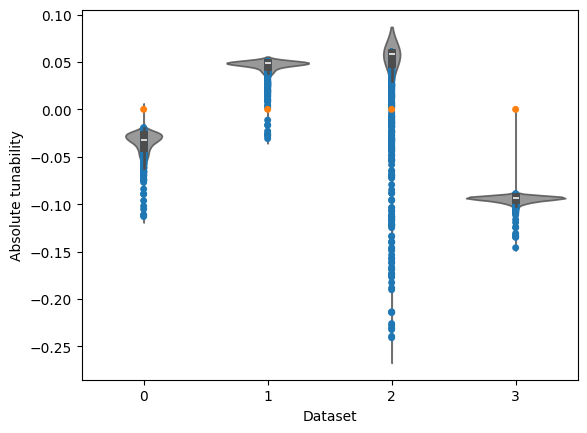

,dataset,params_str,mean_test_score,is_default,abs_tunability,dataset_str
0,0,"{'model__criterion': 'entropy', 'model__max_de...",0.720456,False,-0.183152,0
1,0,"{'model__criterion': 'entropy', 'model__max_de...",0.720456,False,-0.183152,0
2,0,"{'model__criterion': 'entropy', 'model__max_de...",0.720456,False,-0.183152,0
3,0,"{'model__criterion': 'entropy', 'model__max_de...",0.720456,False,-0.183152,0
4,0,"{'model__criterion': 'entropy', 'model__max_de...",0.720456,False,-0.183152,0
...,...,...,...,...,...,...
3991,3,"{'model__criterion': 'gini', 'model__max_depth...",0.777460,False,-0.126147,3
3992,0,"{'model__criterion': 'gini', 'model__max_depth...",0.903608,True,0.000000,0
3993,1,"{'model__criterion': 'gini', 'model__max_depth...",0.903608,True,0.000000,1
3994,2,"{'model__criterion': 'gini', 'model__max_depth...",0.903608,True,0.000000,2


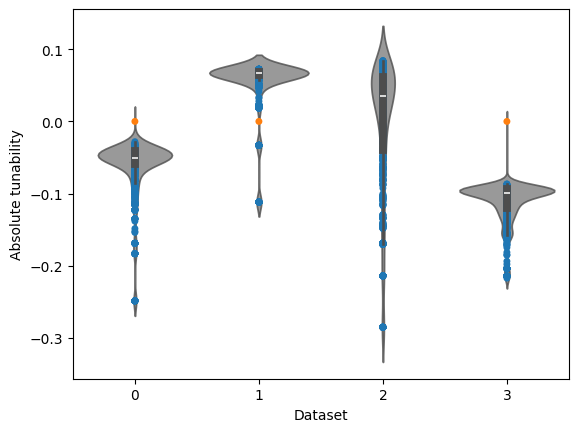

,dataset,params_str,mean_test_score,is_default,abs_tunability,dataset_str
0,0,{'model__max_features': 0.00033350578798328593...,0.807710,False,-0.132633,0
1,0,"{'model__max_features': 0.000443780994426447, ...",0.821638,False,-0.118705,0
2,0,"{'model__max_features': 0.0027118967034302564,...",0.819312,False,-0.121031,0
3,0,"{'model__max_features': 0.002882248784362927, ...",0.872078,False,-0.068265,0
4,0,"{'model__max_features': 0.0032192603860150774,...",0.888957,False,-0.051386,0
...,...,...,...,...,...,...
3999,3,"{'model__max_features': 0.9993535002123353, 'm...",0.836408,False,-0.103935,3
4000,0,"{'model__max_features': 0.49816568848070625, '...",0.940343,True,0.000000,0
4001,1,"{'model__max_features': 0.49816568848070625, '...",0.940343,True,0.000000,1
4002,2,"{'model__max_features': 0.49816568848070625, '...",0.940343,True,0.000000,2


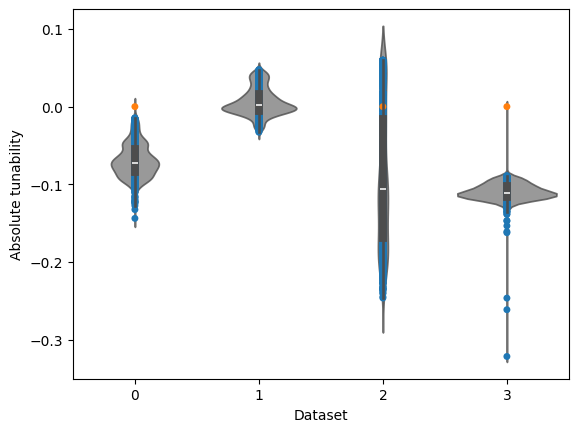

In [10]:
for h in history_RS:
    t = get_tunabilies_per_dataset_for_every_param_set(h,h)
    display(t)
    plot_tunabilities(t)

# ***Bayes Search*** tunability plots

### order of the plots is: **XGBoost**, then **Decision Tree** and in the end **Random Forest**

,dataset,params_str,mean_test_score,is_default,abs_tunability,dataset_str
0,0,"OrderedDict([('model__alpha', 0.0001), ('model...",0.916100,False,-0.023546,0
1,0,"OrderedDict([('model__alpha', 0.0001), ('model...",0.917902,False,-0.021744,0
2,0,"OrderedDict([('model__alpha', 0.0001), ('model...",0.918977,False,-0.020669,0
3,0,"OrderedDict([('model__alpha', 0.0001), ('model...",0.917325,False,-0.022321,0
4,0,"OrderedDict([('model__alpha', 0.00010426811836...",0.914592,False,-0.025054,0
...,...,...,...,...,...,...
399,3,"OrderedDict([('model__alpha', 9.71540102166402...",0.845841,False,-0.093805,3
400,0,"{'model__alpha': 1.2481751282245537, 'model__e...",0.939646,True,0.000000,0
401,1,"{'model__alpha': 1.2481751282245537, 'model__e...",0.939646,True,0.000000,1
402,2,"{'model__alpha': 1.2481751282245537, 'model__e...",0.939646,True,0.000000,2


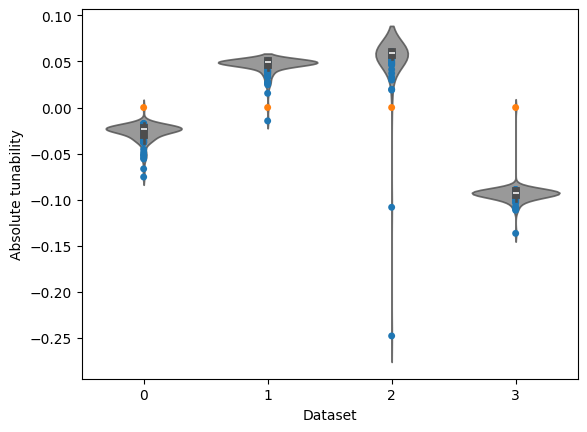

,dataset,params_str,mean_test_score,is_default,abs_tunability,dataset_str
0,0,"OrderedDict([('model__criterion', 'entropy'), ...",0.720456,False,-0.183152,0
1,0,"OrderedDict([('model__criterion', 'entropy'), ...",0.720456,False,-0.183152,0
2,0,"OrderedDict([('model__criterion', 'entropy'), ...",0.868733,False,-0.034874,0
3,0,"OrderedDict([('model__criterion', 'entropy'), ...",0.867510,False,-0.036098,0
4,0,"OrderedDict([('model__criterion', 'entropy'), ...",0.862817,False,-0.040791,0
...,...,...,...,...,...,...
399,3,"OrderedDict([('model__criterion', 'gini'), ('m...",0.812698,False,-0.090910,3
400,0,"{'model__criterion': 'gini', 'model__max_depth...",0.903608,True,0.000000,0
401,1,"{'model__criterion': 'gini', 'model__max_depth...",0.903608,True,0.000000,1
402,2,"{'model__criterion': 'gini', 'model__max_depth...",0.903608,True,0.000000,2


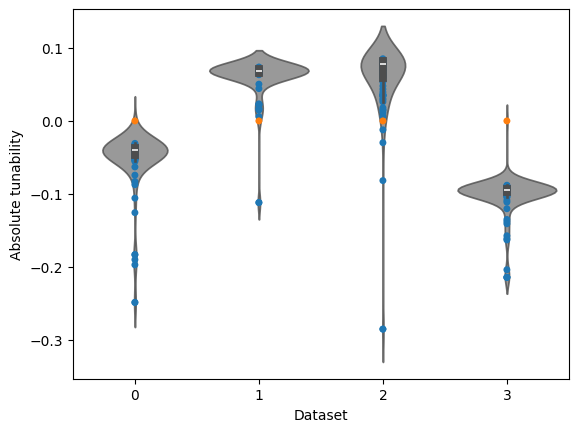

,dataset,params_str,mean_test_score,is_default,abs_tunability,dataset_str
0,0,"OrderedDict([('model__max_features', 0.0036156...",0.823217,False,-0.117125,0
1,0,"OrderedDict([('model__max_features', 0.0036313...",0.830104,False,-0.110238,0
2,0,"OrderedDict([('model__max_features', 0.0049132...",0.843241,False,-0.097101,0
3,0,"OrderedDict([('model__max_features', 0.0839857...",0.916991,False,-0.023351,0
4,0,"OrderedDict([('model__max_features', 0.1261776...",0.921589,False,-0.018754,0
...,...,...,...,...,...,...
399,3,"OrderedDict([('model__max_features', 1e-06), (...",0.618122,False,-0.322220,3
400,0,"{'model__max_features': 0.49816568848070625, '...",0.940343,True,0.000000,0
401,1,"{'model__max_features': 0.49816568848070625, '...",0.940343,True,0.000000,1
402,2,"{'model__max_features': 0.49816568848070625, '...",0.940343,True,0.000000,2


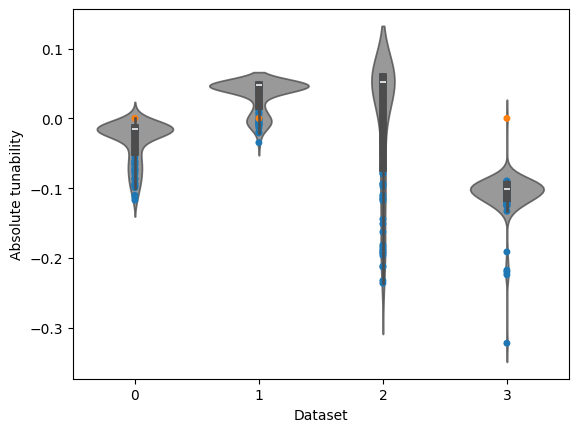

In [11]:
for h,r in zip(history_BS, history_RS):
    t = get_tunabilies_per_dataset_for_every_param_set(h,r)
    display(t)
    plot_tunabilities(t)

In [13]:
def plot_tunabilities(tunabilites, ax = None):
    if ax is None: 
        fig,ax = plt.plot()
    sns.violinplot(tunabilites,
              x='dataset_str',
              y='abs_tunability',
              alpha = 0.8,
              color="gray", ax=ax)
    sns.stripplot(tunabilites,
                x='dataset_str',
                y='abs_tunability',
                hue='is_default',
                legend=False,
                jitter=False, 
                zorder = 1, ax=ax)

    ax.set_xlabel('Dataset')
    ax.set_ylabel('Absolute tunability')

    return ax

# Comparison of these plots below

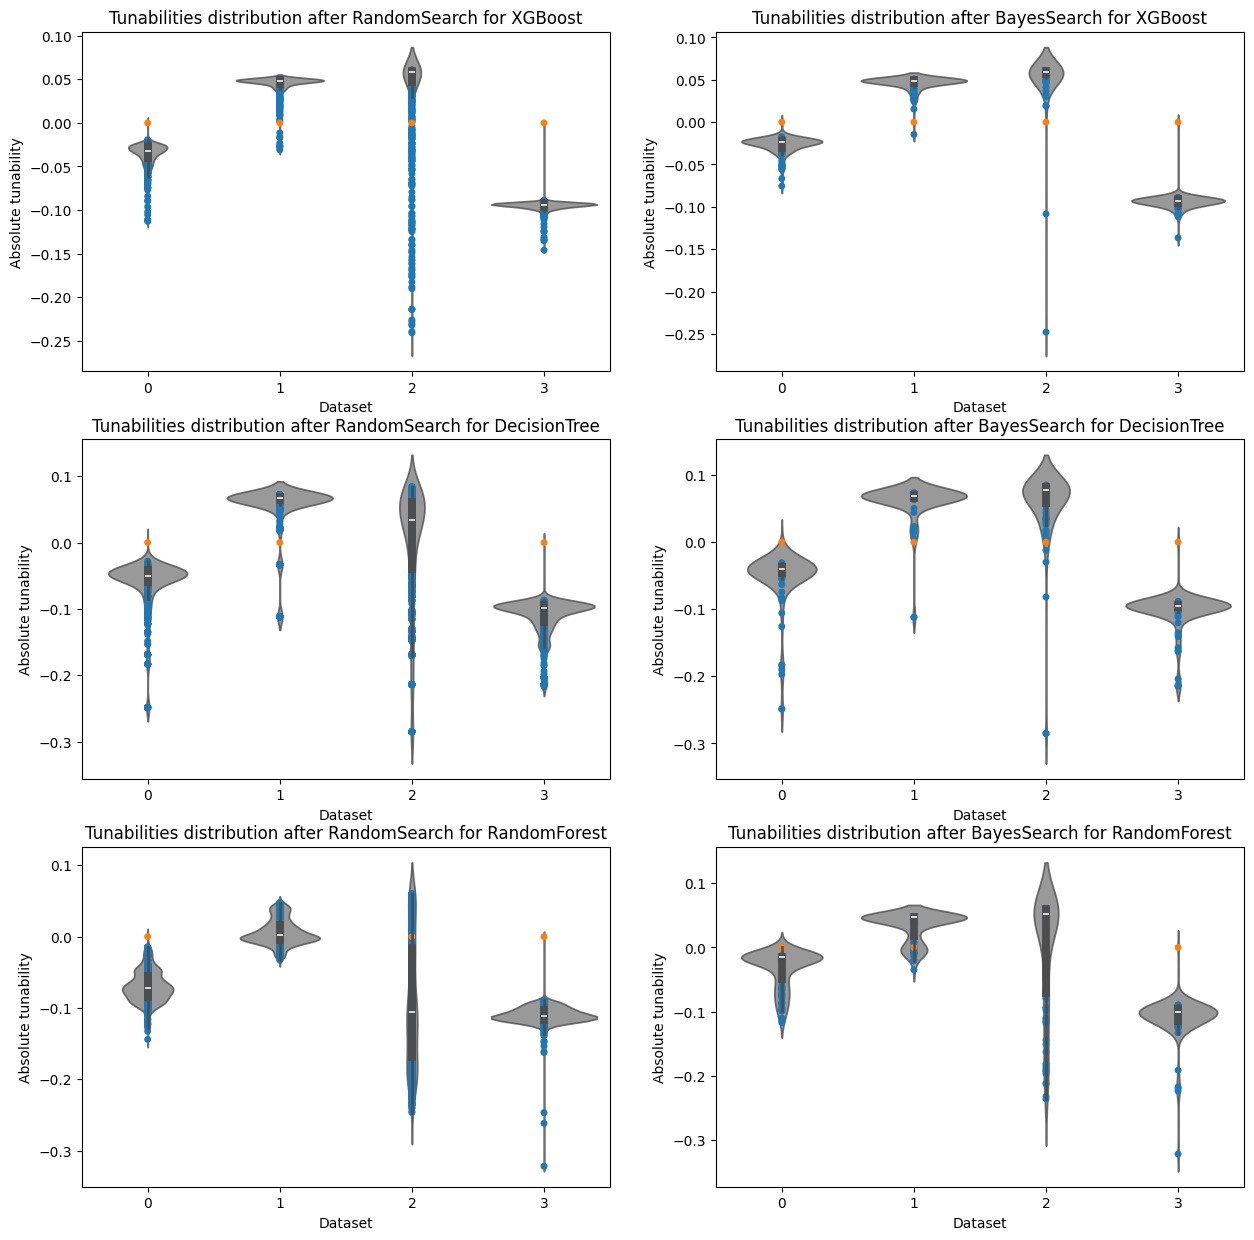

In [14]:
fig, axs = plt.subplots(len(history_RS), 2, figsize = [15,15])

names = ["XGBoost","DecisionTree", "RandomForest"]

for i,(rs, bs) in enumerate(zip(history_RS, history_BS)):
    trs = get_tunabilies_per_dataset_for_every_param_set(rs,rs)
    tbs = get_tunabilies_per_dataset_for_every_param_set(bs,rs)
    plot_tunabilities(trs, axs[i,0])
    plot_tunabilities(tbs, axs[i,1])

    axs[i,0].set_title(f"Tunabilities distribution after RandomSearch for {names[i]}")
    axs[i,1].set_title(f"Tunabilities distribution after BayesSearch for {names[i]}")

plt.show()
